In [4]:
# Author: Antti Kiviaho
# Date 24.2.2023
#
# This script is for merging clusters from separate Visium experiments/samples.
# The clusters are derived from a combination of GE and spatial proximity graph
# The shared latent space is derived from SCANORAMA integration.
# Now we merge clusters in this space using MNN and silhouette scores.

## Merging sample specific clusters to find joint clusters in the scanorama space.
The criteria here is that a cluster is merged with it's closest (Euclidean distance in the 100 dim space)
cluster if 
1) this improves the mean silhouette score of both clusters.
2) the nearest cluster originates from a different sample.

In [5]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, pairwise_distances
import seaborn as sns
from  scripts.utils import load_from_pickle,save_to_pickle, get_sample_ids
from pathlib import Path
from matplotlib import pyplot as plt

In [6]:
# Load data
adata_scanorama = load_from_pickle('./data/visium_after_scanorama_clustered.pickle')
normalized_adata = load_from_pickle('./data/clustered_visium_data.pickle')
samples = get_sample_ids()

In [7]:
# Define functions

## Calclulates the euclidean distance on cluster level yield to information about which clusters are closest to each other
def calculate_distances(cluster_means_df,n_closest=5):
    closest_names = np.empty((0,n_closest))
    closest_dist = np.empty((0,n_closest))

    for idx in range (len(cluster_means_df)):

        # Divide the df into the query (1 cluster) and the rest
        comparison_dat = cluster_means_df.iloc[idx]
        rest_of_the_dat = cluster_means_df.drop(index=[cluster_means_df.index[idx]])

        # Repeat one row to match the shape of the rest
        comparison_dat_reshaped = np.tile(comparison_dat,(rest_of_the_dat.shape[0],1))
        res = np.linalg.norm(rest_of_the_dat-comparison_dat_reshaped,axis=1)
        matches = np.asarray(list(rest_of_the_dat.index[np.argsort(res)[:n_closest]]))

        # Stack names and distances of closest matches
        closest_names = np.vstack([closest_names,matches])
        closest_dist = np.vstack([closest_dist,np.sort(res)[:n_closest]])

    # Convert to dataframes for easy slicing
    closest_names = pd.DataFrame(closest_names,index=cluster_means_df.index)
    closest_dist = pd.DataFrame(closest_dist,index=cluster_means_df.index)
    return(closest_names,closest_dist)

# Compare sample names of the index and the first column to find if the nearest cluster is from another sample. Only keep those
def find_nearest_neighbors(df):
    slices = []
    for idx in range(len(df)):
        if (('_').join(df.index[idx].split('_')[:-1]) != 
        ('_').join(df[0][idx].split('_')[:-1])):
            slices.append(idx)

    # These are the spatial clusters with different sample nearest cluster
    return(df.iloc[slices])

# Keep clusters that are mutual nearest neighbors (MNN)
def find_mnn_clusters(df):
    slices = []
    for idx in range(len(df)):
        if (df[0][idx] in df.index):
            if df.loc[df[0][idx]][0] == df.index[idx]:
                if df[0][idx] not in df.iloc[slices].index:
                    slices.append(idx)

    # These are the spatial clusters with mutual nearest neighbors
    return(df.iloc[slices])


def has_no_duplicates(cluster_list):
    '''
    Check if a sample is duplicated in a cluster
    '''
    return(len([('_').join(s.split('_')[:-1]) for s in cluster_list]) == len(
        set([('_').join(s.split('_')[:-1]) for s in cluster_list])))
    

In [8]:
# Extracts spot level scanorama coordinates and averages to cluster level for mutual nearest neighbor comparison
n_comps = 100
spot_lvl_data = pd.DataFrame(adata_scanorama.obsm['X_scanorama'],index=adata_scanorama.obs_names).iloc[:,:n_comps]
spot_lvl_data['spatial_cluster'] = adata_scanorama.obs['spatial_cluster']
spot_lvl_labs = adata_scanorama.obs['spatial_cluster']

# Speeds up the analysis a little bit
distance_array = pairwise_distances(adata_scanorama.obsm['X_scanorama'][:,:n_comps])
ref_score = silhouette_score(distance_array,spot_lvl_labs,metric='precomputed')
ref_score # = -1 # If the reference score is set to -1, we effectively lose the silhouette score if-clause

# A scanorama-based clustering silhouette score is 0.06169539683589392 


-0.011346956467665394

In [9]:
def is_score_ok(new_labs,df=distance_array, reference = ref_score):
    '''
    Checks the silhouette score of new clustering labels and compares them to a reference of 
    the original clustering
    '''
    new_score = silhouette_score(df,new_labs,metric='precomputed')
    if new_score > reference:
        return(True)
    else:
        return(False)

In [10]:

it = 1
prev_iteration = 0
while True:
    if 'modified_labs' in locals():
        # Change the labels by which means are calculated
        spot_lvl_data['spatial_cluster'] = modified_labs
    else:
        modified_clusters = dict()

    # Calculate cluster means in the scanorama space
    cluster_lvl_dat = spot_lvl_data.groupby('spatial_cluster').mean()

    # Calculate euclidean distance between the clusters
    names, dist = calculate_distances(cluster_lvl_dat)

    # Find MNN clusters that are from different samples
    filtered_names = find_nearest_neighbors(names)
    cluster_pairs = find_mnn_clusters(filtered_names)
    
    # The break condition: If there are no more eligible clusters to merge.
    if len(cluster_pairs) == prev_iteration:                                              # REPLACE THIS WITH ANOTHER CONDITION, SINCE SOME CLUSTERS LINGER
        print('Ran for '+ str(it)+ ' iterations.')
        print('Merged clusters:')
        print(modified_clusters)
        break

    prev_iteration = len(cluster_pairs)
    n = 1
    # Find mergeable clusters by checking different conditions
    # Iterate over the clusters
    for idx in range(len(cluster_pairs)):
        inst_1 = str(cluster_pairs.index[idx])
        inst_2 = str(cluster_pairs.iloc[idx][0])
        message = (inst_1 + ' <--> ' + inst_2 + ' merge improves the score!')

        # Check if the index is already a merged cluster
        if inst_1 in modified_clusters.keys():
            prev_lst = modified_clusters[inst_1]
            replaced = prev_lst + [inst_2]
            if is_score_ok(spot_lvl_labs.replace(replaced,'test_cluster')) & has_no_duplicates(replaced):
                print(message)
                print()
                modified_clusters[inst_1] = replaced

        # Check if the first column is already a merged cluster
        elif inst_2 in modified_clusters.keys():
            prev_lst = modified_clusters[inst_2]
            replaced = prev_lst + [inst_1]
            if is_score_ok(spot_lvl_labs.replace(replaced,'test_cluster')) & has_no_duplicates(replaced):
                print(message)
                print()
                modified_clusters[inst_2] = replaced
        
        # If neither is a modified cluster, create a new cluster and save it
        else:
            replaced = [inst_1,inst_2]
            if is_score_ok(spot_lvl_labs.replace(replaced,'test_cluster')) & has_no_duplicates(replaced):
                print(message)
                print()
                modified_clusters['new_clust_'+str(n)] = replaced
                n+=1

    modified_labs = spot_lvl_labs.copy()
    for k in modified_clusters.keys():
        modified_labs = modified_labs.replace(modified_clusters[k],k)

    print('Iteration '+ str(it) + ' completed.')
    print()
    it+=1


BPH_651_3 <--> CRPC-489_0 merge improves the score!

BPH_651_6 <--> CRPC-489_1 merge improves the score!

BPH_688_4 <--> PC_4980_3 merge improves the score!

CRPC-278_2 <--> CRPC-697_2 merge improves the score!

PC_00_16338_II_4 <--> PC_01_06342_VAS_2 merge improves the score!

PC_01_06342_VAS_3 <--> PC_01_14451_OIK_7 merge improves the score!

PC_02_05601_OIK_6 <--> PC_03_01669_TUTKV_1 merge improves the score!

PC_15420OIK_1 <--> PC_4980_1 merge improves the score!

PC_4980_0 <--> PC_7875OIK_0 merge improves the score!

Iteration 1 completed.

new_clust_2 <--> PC_7875OIK_1 merge improves the score!

new_clust_3 <--> PC_15420OIK_0 merge improves the score!

Iteration 2 completed.

Iteration 3 completed.

Ran for 4 iterations.
Merged clusters:
{'new_clust_1': ['BPH_651_3', 'CRPC-489_0'], 'new_clust_2': ['BPH_651_6', 'CRPC-489_1', 'PC_7875OIK_1'], 'new_clust_3': ['BPH_688_4', 'PC_4980_3', 'PC_15420OIK_0'], 'new_clust_4': ['CRPC-278_2', 'CRPC-697_2'], 'new_clust_5': ['PC_00_16338_II_4', 

In [11]:
# Save the data object with the labels to a pickle file.
adata_scanorama.obs['merged_spatial_clusters'] = modified_labs
adata_scanorama.uns['merged_spatial_clusters_dict'] = modified_clusters

In [12]:
# Copy the merged clustering to individual spatial sections
identifier = 'merged_spatial_clusters' # spatial_cluster, sample_id, clusters
for s in samples:
    if (normalized_adata[s].obs_names ==
    adata_scanorama[adata_scanorama.obs['sample_id']==s].obs_names).all():
        normalized_adata[s].obs[identifier] = adata_scanorama[adata_scanorama.obs['sample_id']==s].obs[identifier].copy()



In [13]:
# Saving data objects...
#save_to_pickle(adata_scanorama,'./data/visium_after_scanorama_with_all_embeddings.pickle')
#save_to_pickle(normalized_adata,'./data/individual_sections_normalized_clustered.pickle')

## Visualize the clusters on UMAP and on sections

/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


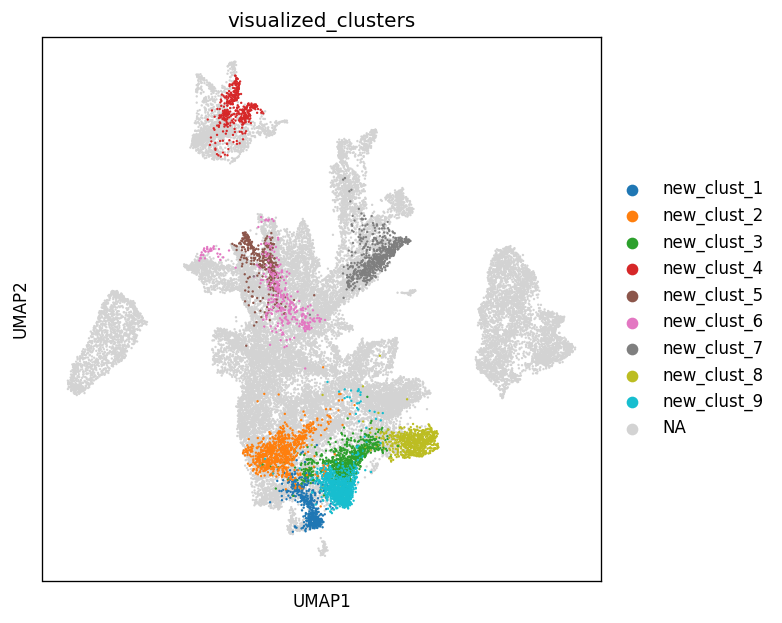

In [14]:
identifier = 'merged_spatial_clusters' # spatial_cluster, sample_id, clusters
targets = adata_scanorama.obs[adata_scanorama.obs[identifier].isin(modified_clusters)][identifier].unique()
targets = targets.remove_unused_categories()

adata_scanorama.obs['visualized_clusters'] = adata_scanorama.obs[identifier][adata_scanorama.obs[identifier].isin(targets)]
adata_scanorama.obs['visualized_clusters'] = adata_scanorama.obs['visualized_clusters'].cat.set_categories(targets)

fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(6,6)
fig.set_dpi(120)
sc.pl.umap(adata_scanorama, color=['visualized_clusters'],ax=ax1,size=8,frameon=True,palette='tab10')

In [15]:
identifier = 'merged_spatial_clusters' # joint_leiden_clusters, sample_id
img_dir_path = './plots/merged_spatial_clusters_on_sections'
Path(img_dir_path).mkdir(parents=True, exist_ok=True)
for sample in samples:
    targets = adata_scanorama.obs[identifier].unique()
    targets = [t for t in targets if 'new_clust' in t]

    adata_vis = normalized_adata[sample].copy()
    adata_vis.obs['visualized_clusters'] = adata_vis.obs[identifier][adata_vis.obs[identifier].isin(targets)].cat.set_categories(targets)

    fig,ax1 = plt.subplots(1,1)
    fig.set_size_inches(12,12)
    fig.set_dpi(150)
    sq.pl.spatial_scatter(adata_vis,color=['visualized_clusters'],ax=ax1,size=1.2,frameon=False,palette='tab10')
    
    plt.tight_layout()
    fig.savefig(img_dir_path+'/'+sample+'.png')
    fig.clf()

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>